## 1. Install dependencies and Import Libraries

In [67]:
!pip install pandas numpy scikit-learn matplotlib seaborn transformers datasets torch

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

import re
import string
import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

import multiprocessing as mp

In [69]:
mp.set_start_method("spawn", force=True)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # If GPU available
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    
    # If using MPS on Mac
    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)

    # Ensure deterministic behavior where possible
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [70]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

Using device: mps


## 2. Load the dataset

In [38]:
# Load the dataset
df = pd.read_csv("data/labeled_data.csv")
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [39]:
# Keep only the text + label
df = df[['class', 'tweet']].rename(columns={'class': 'label', 'tweet': 'text'})
df.head()

,label,text
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [40]:
df.shape

(24783, 2)

In [41]:
df.isna().sum()

label    0
text     0
dtype: int64

In [42]:
df['label'].value_counts()

label
1    19190
2     4163
0     1430
Name: count, dtype: int64

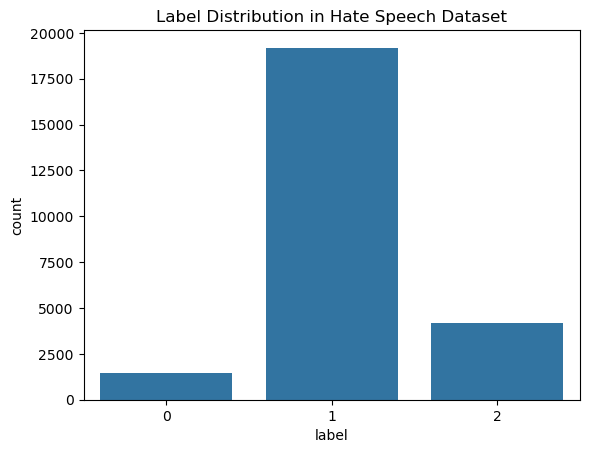

In [43]:
sns.countplot(data=df, x='label')
plt.title("Label Distribution in Hate Speech Dataset")
plt.show()

## 3. Preprocessing

In [44]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/thaneesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [45]:
stop_words = set(stopwords.words('english'))

def clean_text(text, remove_stopwords=False):
    # lowercase
    text = text.lower()
    
    # remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # remove mentions (@user)
    text = re.sub(r'@\w+', '', text)
    
    # remove hashtags (#word → word)
    text = re.sub(r'#', '', text)
    
    # remove numbers
    text = re.sub(r'\d+', '', text)
    
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    # optional stopword removal
    if remove_stopwords:
        text = " ".join([word for word in text.split() if word not in stop_words])
    
    return text

In [46]:
df['clean_text'] = df['text'].apply(lambda x: clean_text(x, remove_stopwords=False))
df.head(10)

,label,text,clean_text
0,2,!!! RT @mayasolovely: As a woman you shouldn't...,rt as a woman you shouldnt complain about clea...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,rt boy dats coldtyga dwn bad for cuffin dat ho...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,rt dawg rt you ever fuck a bitch and she start...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,rt she look like a tranny
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,rt the shit you hear about me might be true or...
5,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just...",the shit just blows meclaim you so faithful an...
6,1,"!!!!!!""@__BrighterDays: I can not just sit up ...",i can not just sit up and hate on another bitc...
7,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of...,cause im tired of you big bitches coming for u...
8,1,""" &amp; you might not get ya bitch back &amp; ...",amp you might not get ya bitch back amp thats ...
9,1,""" @rhythmixx_ :hobbies include: fighting Maria...",hobbies include fighting mariam bitch


## 4. Train–test split + TF-IDF Baseline Model

### Create Train-test split

In [47]:
X = df['clean_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 19826
Test size: 4957


In [48]:

# compute weights for labels 0, 1, 2
# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(y_train),
#     y=y_train
# )
# Automatically computed weights - [5.7768, 0.4305, 1.9846]

# Adjusted weights
class_weights = [3.0, 0.8, 1.2]

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class weights:", class_weights)

Class weights: tensor([3.0000, 0.8000, 1.2000], device='mps:0')


### TF-IDF vectorizer

In [49]:
tfidf = TfidfVectorizer(
    max_features=5000,       # keep top 5k words
    ngram_range=(1,2),       # unigrams + bigrams
    stop_words='english'     # safe because we cleaned text
)

In [50]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

### Train the Logistic Regression baseline

In [51]:
model = LogisticRegression(max_iter=200, n_jobs=-1)
model.fit(X_train_tfidf, y_train)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

LogisticRegression(max_iter=200, n_jobs=-1)

### Predictions

In [52]:
y_pred = model.predict(X_test_tfidf)

### Evaluation Metrics

In [53]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.15      0.24       286
           1       0.91      0.97      0.94      3838
           2       0.86      0.81      0.83       833

    accuracy                           0.89      4957
   macro avg       0.77      0.64      0.67      4957
weighted avg       0.88      0.89      0.88      4957



### Confusion Matrix

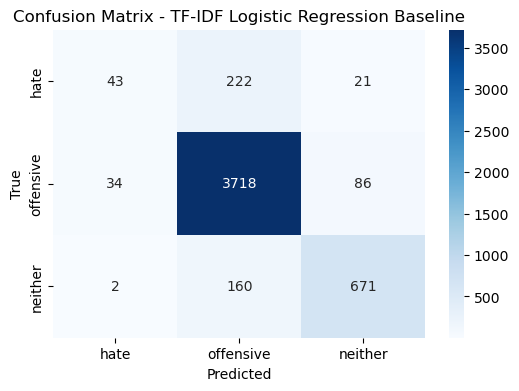

In [54]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['hate','offensive','neither'],
            yticklabels=['hate','offensive','neither'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - TF-IDF Logistic Regression Baseline")
plt.show()

## 5. DistilBERT Fine-Tuning

### Load DistilBERT tokenizer

In [55]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

### Dataset class for PyTorch

In [56]:
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = list(texts)
        self.labels = list(labels)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        enc = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': enc['input_ids'].flatten(),
            'attention_mask': enc['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

### Create train/test datasets & dataloaders

In [57]:
train_dataset = HateSpeechDataset(X_train, y_train, tokenizer)
test_dataset  = HateSpeechDataset(X_test, y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

In [58]:
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [59]:
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


### Optimizer & scheduler

In [60]:
epochs = 3
# learning rate 2e-5, 1e-5
optimizer = AdamW(model.parameters(), lr=1e-5)

total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

### Training loop

In [61]:
train_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )

        # loss = outputs.loss
        logits = outputs.logits
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits, labels)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f}")
    train_losses.append(avg_train_loss)

Epoch 1/3 | Train Loss: 0.5318


Exception ignored in: <function ResourceTracker.__del__ at 0x106165bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104fd1bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106fd1bc0>
Traceback (most recent call last

Epoch 2/3 | Train Loss: 0.3392
Epoch 3/3 | Train Loss: 0.2855


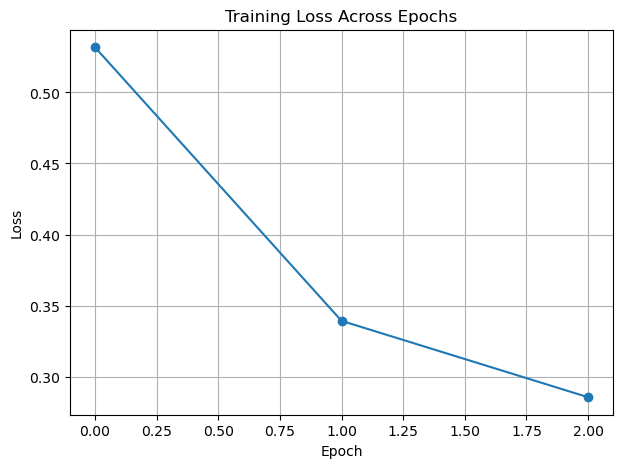

In [62]:
plt.figure(figsize=(7,5))
plt.plot(train_losses, marker='o')
plt.title("Training Loss Across Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

### Evaluation

In [63]:
model.eval()
preds = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1).cpu().numpy()

        preds.extend(predictions)
        true_labels.extend(batch['labels'].numpy())

### Classification report

In [64]:
print(classification_report(true_labels, preds))

              precision    recall  f1-score   support

           0       0.45      0.58      0.51       286
           1       0.96      0.93      0.95      3838
           2       0.88      0.91      0.90       833

    accuracy                           0.91      4957
   macro avg       0.77      0.81      0.78      4957
weighted avg       0.92      0.91      0.91      4957



### Confusion matrix

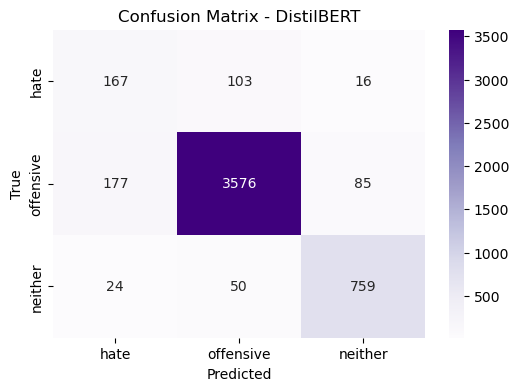

In [65]:
cm = confusion_matrix(true_labels, preds)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Purples',
    xticklabels=['hate','offensive','neither'],
    yticklabels=['hate','offensive','neither']
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - DistilBERT")
plt.show()


In [66]:
cm

array([[ 167,  103,   16],
       [ 177, 3576,   85],
       [  24,   50,  759]])